# Splitting and recombining images using unfold/fold

This notebook demonstrates how to use PyTorch's `nn.Unfold` to split an images into overlapping subimages, then how to use `nn.Fold` to reconstruct the original image from the subimages.

There must be an integer number of overlapping subimages in each dimension of the original image. The number of subimages in one dimension (here, x) can be calculated using: n = ((xpixels - xkernel_size) / xstride) + 1
where xpixels is the size of the image in the x axis, xkernel is the width of the subimage in the x zxis, and xstride is the stride between subimages. Overlap occurs when xstride < xkernel_size.


In [39]:
from skimage import io, transform
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

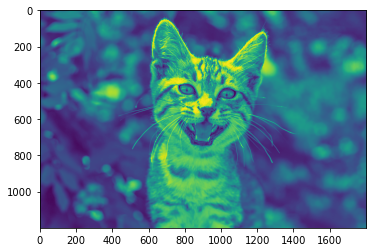

In [40]:
im = torch.from_numpy(np.array(io.imread('cat.jpg')))
im = im.sum(dim=2)
im.unsqueeze_(0).unsqueeze_(0)
plt.imshow(im[0,0,...])
plt.show()

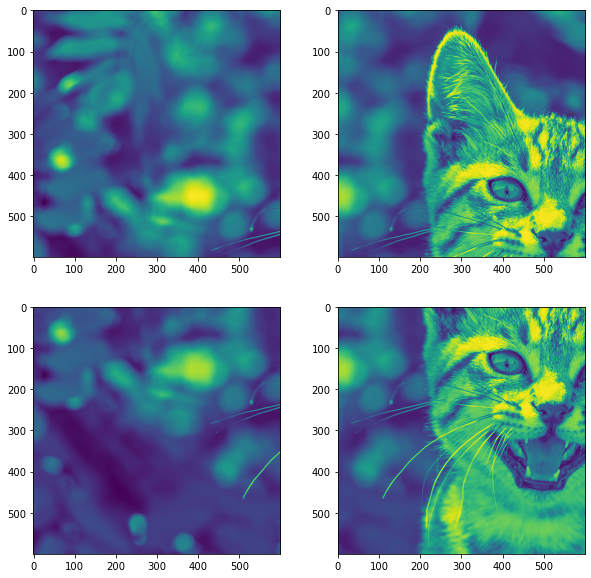

In [41]:
size, stride = ((600,600), (300,400))
nx = int((im.shape[3] - size[1]) / stride[1] + 1)
ny = int((im.shape[2] - size[0]) / stride[0] + 1)

# Unfold (i.e., split) the image.
unfolder = nn.Unfold(kernel_size=size, stride=stride)
patches = unfolder(im.float()).reshape(size[0],size[1],ny,nx)

# Permute the patches so that they have the correct dimensionality for
# PyTorch, with [ny,nx] as the final two dimensions.
patches = patches.permute(2,3,0,1)

# Plot the images to make sure they look ok. Are they overlapping?
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(patches[0,0,...])
ax[0,1].imshow(patches[0,1,...])
ax[1,0].imshow(patches[1,0,...])
ax[1,1].imshow(patches[1,1,...])
fig.show()

In [42]:
# Permute back to reconstruct the original images, and reshape:
patches = patches.permute(2,3,0,1).reshape(1,-1,nx*ny)

# Fold to reconstruct the image:
folder = nn.Fold(output_size=im.shape[2:], 
                 kernel_size=size, stride=stride)
reconstructed = folder(patches)

# This is needed to sort out the normalisation; see torch.nn.Unfold documentation
im_ones = torch.ones(im.shape, dtype=float)
divisor = folder(unfolder(im_ones))
folded = reconstructed / divisor

torch.Size([1, 1, 1200, 1800]) torch.Size([1, 1, 1200, 1800])


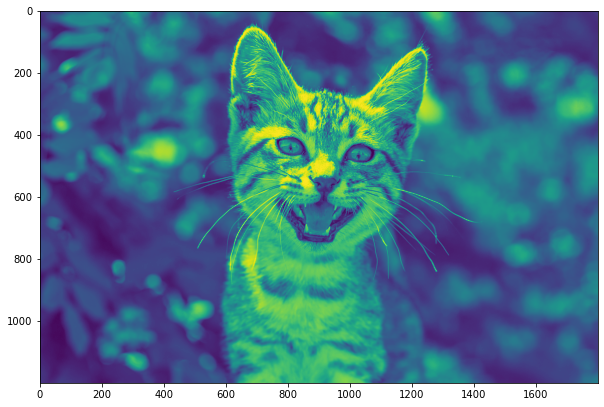

In [43]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(folded[0,0,...])
fig.show()